## Introduction
This notebook consists of two parts:     
1- Classifying the Adult Income data set using predictive modeling       
2- Report   

## 1- Classifying the Adult Income data set using predictive modeling
The problem of classifying adult income (is the income of an adult > 50K or <= 50K?) will be studied. Python scikit-learn machine learning package is used and 3 different predictive models will be tested:    
1- Logistic Regression       
2- Decision Tree      
3- Random Forest   
   

### Functions
The following functions were created to read, discover, splitting into training/testing sets, modeling and predicting data, and visualizing results. 

In [370]:
# importing required packages
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
from collections import Counter
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams.update({'font.size': 14})

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings("ignore")

# 1
def importing_data(path):
    ''' importing data '''
    df = pd.read_csv(path, header = None, na_values = ' ?')
    df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 
                   'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'adult_income']
    return df

# 2
def cleaned_data(df):
    ''' cleaning data '''
    df_ = df.copy()
    df_ = df.dropna()    
    return df_

# 3
def trn_tst_split(df, target, test_size = 0.2, random_state = 2020):
    '''splitting data into training and testing sets '''
    df_ = df.copy()
    
    X, y = df_.loc[:, ~df_.columns.isin([target])], df_[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)
    return X_train, X_test, y_train, y_test

# 4
def label_encoding_rescale(df):
    ''' Auto encodes any dataframe column of type category or object, and rescale any int/float type  '''
    cat_features = list(df.select_dtypes(include = ['category', 'object']))
    num_features = list(df.select_dtypes(include = ['int64', 'float64']))
    le = LabelEncoder()
    scaler = MinMaxScaler()
    #df[num_features] = scaler.fit_transform(df[num_features])
    for cat_feature in cat_features:
        try:
            df[cat_feature] = le.fit_transform(df[cat_feature])
        except:
            print('Error encoding: ' + cat_feature)
    df[list(df.columns)] = scaler.fit_transform(df[list(df.columns)])
    return df

# 5
def classifiers(class_weight = None):
    ''' defining the models that will be used in classification, class_weight = None or 'balanced' '''
    rs = 2020
    clsf = []
    clsf.append(('LR', LogisticRegression(class_weight = class_weight, random_state = rs)))
    clsf.append(('DT', DecisionTreeClassifier(class_weight = class_weight, random_state = rs)))
    clsf.append(('RF', RandomForestClassifier(class_weight = class_weight, random_state = rs)))
    return dict(clsf)

# 6
def train_classifier(clsf, X_train, y_train): 
    '''training a classifier to fit a trained set'''
    model = clsf.fit(X_train, y_train)
    return model 

# 7
def predict_labels(model, X_test):
    '''using the classifier to predict labels of test set'''
    y_pred = model.predict(X_test)
    return y_pred  

# 8
def accuracy_confusion(clsf, X_train, y_train, X_test, y_test):
    ''' getting accuracy for each model and predicted labels and the confusion matrix '''
    clsf_key = []
    scores = []
    #df_pred = []
    target_names = ['0', '1']  
    for key, value in clsf.items():
        model = train_classifier(value, X_train, y_train)     # training classifier by using the training set
        y_pred = predict_labels(model, X_test)     # testing the classifier by using test set
        #print(X_test.shape, y_pred.shape, y_test.shape)
        cnf_matrix = confusion_matrix(y_test, y_pred)    # getting the confusion matrix
        print(' Model: ' + key, '\n', classification_report(y_test, y_pred, target_names = target_names), '\n')
        clsf_key.append(key)
        scores.append(accuracy_score(y_test, y_pred))  # calculating Accuracy of each model        
        print('\n', 'Accuracy of the ' + '"' + key + '"' + ' model = ', round(accuracy_score(y_test, y_pred) * 100, 2), '%', '\n' )
        plot_confusion_matrix(key, y_test, y_pred, target_names, True)   
        print(60 * '=')
    df_scores = pd.DataFrame({'Classifier': clsf_key, 'Score': scores})
    return df_scores.sort_values(by = 'Score', ascending = False).reset_index(drop = True)

# 9
def random_over_sampling(X_train, y_train):
    ''' performing random over sampling to convert imbalanced data into balanced '''
    ros = RandomOverSampler(random_state = 2020)
    X_ros, y_ros = ros.fit_resample(X_train, y_train)
    print('ros shape for features) :   {}'.format(X_ros.shape))
    print('ros shape for labels) :   {}'.format(y_ros.shape))
    return X_ros, y_ros

# 10
def plot_confusion_matrix(k, y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes  #[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('normalized confusion matrix of the ' + '"' + k + '"' + ' model ' )
    else:
        print('confusion matrix of the ' + '"' + k + '"' + ' model ')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

#%% 

In [371]:
#print module versions for reproducibility
import matplotlib
import imblearn
print('Numby version {}'.format(np.__version__))
print('Pandas version {}'.format(pd.__version__))
print('Matplotlib version {}'.format(matplotlib.__version__))
print('PandasProfiling version {}'.format(pandas_profiling.__version__))
print('Sklearn version {}'.format(sklearn.__version__))
print('Imblearn version {}'.format(imblearn.__version__))

Numby version 1.16.5
Pandas version 0.25.1
Matplotlib version 3.1.1
PandasProfiling version 2.3.0
Sklearn version 0.21.3
Imblearn version 0.5.0


In [294]:
path = r'D:\tech_test\Partnerize\adult.data'     # adult income data path
df = importing_data(path)                        # importing data as a pandas dataframe

### Exploring the data
Instead of using Pandas package to explore the data, I will use **Pandas Profiling** package which is a great package that could be used to analyze the data and to get an overview about variables, data types, missing values and visualizing the data. In only one line of code you will have the data analyzed, please see the **full_report** below:

In [235]:
full_report = pandas_profiling.ProfileReport(df)   # data exploring full report

In [236]:
full_report


The main aim of this work is to predict the adult income, ['adult_income'] label, by using all or some of the features above, i.e, ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 
                   'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'].       
From the **full_report** I noticed three important things:       
- The data has 6 numeric features and 8 categorical features, in adition to the target column 
- 1.8% of df['native-country'], 5.7% of df['occupation'] and 5.6% of df['workclass'] values are missing, To deal with this issue, since the ratio of the missing values to the number of instances of df is small then I will drop them off of df
- The data could be considered as an **imbalanced data** because 75.9% of adult income <= 50K and 24.1% of the income is > 50K. So, the problem that we are going to solve need to be handled carefully before using machine learning to build the predictive model. Three different approaches will be introduced:
    * ignoring class weight, i.e, using imbalanced data as it is (class_weight = None)
    * setting class_weight = 'balance', where the class weights for unbalanced classes of the dataset will be estimated 
    * the random oversampling method from **imblearn** package will be used to convert imbalanced data into balanced one      
Details are given below:

### Modifying the dataset
Here, the function **cleaned_data(df)** is used to drop off the missing values from **df**, then the categorical columns are encoded and rescaled between (0, 1)by using the function **label_encoding_rescale**. Then the new data frame is called **df_mod**.   

In [313]:
df_mod = label_encoding_rescale(cleaned_data(df))   # removing the Nan values and encodeing the categorical features

In [297]:
df_mod.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,adult_income
0,0.301370,0.833333,0.043338,0.600000,0.800000,0.666667,0.000000,0.2,1.0,1.0,0.02174,0.0,0.397959,0.95,0.0
1,0.452055,0.666667,0.047277,0.600000,0.800000,0.333333,0.230769,0.0,1.0,1.0,0.00000,0.0,0.122449,0.95,0.0
2,0.287671,0.333333,0.137244,0.733333,0.533333,0.000000,0.384615,0.2,1.0,1.0,0.00000,0.0,0.397959,0.95,0.0
3,0.493151,0.333333,0.150212,0.066667,0.400000,0.333333,0.384615,0.0,0.5,1.0,0.00000,0.0,0.397959,0.95,0.0
4,0.150685,0.333333,0.220703,0.600000,0.800000,0.333333,0.692308,1.0,0.5,0.0,0.00000,0.0,0.397959,0.10,0.0


### Feature importance
Here, I will use the random forest classifier to get the features importance of the data:

                feature_importance
fnlwgt                    0.171908
age                       0.145146
capital-gain              0.120314
relationship              0.112309
education-num             0.102548
hours-per-week            0.078715
marital-status            0.070122
occupation                0.069083
workclass                 0.038673
capital-loss              0.031115
education                 0.025672
native-country            0.014865
race                      0.013894
sex                       0.005636


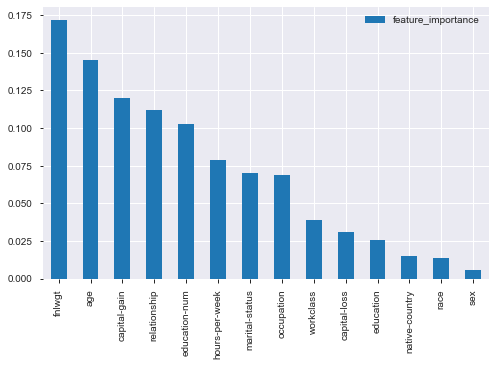

In [304]:
rfc_model = RandomForestClassifier(random_state = 2020)
rfc_model.fit(df_mod.drop(columns=['adult_income']), df_mod['adult_income'])
features_importance = pd.DataFrame(rfc_model.feature_importances_, index = X_train.columns, columns=['feature_importance']).sort_values(by ='feature_importance', ascending = False)
print(features_importance)
features_importance.plot(kind='bar')

From the figure above, it is obvious that the first 8 features is more important than the other features. So, I'll use them on modeling step. Now the modified data frame is:

In [346]:
df_mod = df_mod[list(features_importance.index)[:8] + ['adult_income']]

In [347]:
df_mod.head()

,fnlwgt,age,capital-gain,relationship,education-num,hours-per-week,marital-status,occupation,adult_income
0,0.043338,0.301370,0.02174,0.2,0.800000,0.397959,0.666667,0.000000,0.0
1,0.047277,0.452055,0.00000,0.0,0.800000,0.122449,0.333333,0.230769,0.0
2,0.137244,0.287671,0.00000,0.2,0.533333,0.397959,0.000000,0.384615,0.0
3,0.150212,0.493151,0.00000,0.0,0.400000,0.397959,0.333333,0.384615,0.0
4,0.220703,0.150685,0.00000,1.0,0.800000,0.397959,0.333333,0.692308,0.0


### Train_test split the dataset
The function **trn_tst_split** is used to split the cleaned dataset into train set (80%) and test set (20%):

In [348]:
target = 'adult_income'
X_train, X_test, y_train, y_test = trn_tst_split(df_mod, target) # traim_test_split the df

In [349]:
X_train.head()

,fnlwgt,age,capital-gain,relationship,education-num,hours-per-week,marital-status,occupation
24674,0.067528,0.109589,0.0,0.2,0.533333,0.397959,0.833333,0.153846
29712,0.059612,0.397260,0.0,1.0,0.533333,0.397959,0.333333,0.000000
31133,0.082239,0.178082,0.0,0.6,0.600000,0.448980,0.666667,0.000000
24388,0.244828,0.273973,0.0,0.2,0.600000,0.346939,0.833333,0.384615
17711,0.043782,0.054795,0.0,0.2,0.533333,0.418367,0.666667,0.153846


In [350]:
print(' Shape of training sample ', X_train.shape)
print(' Shape of training label ', y_train.shape)
print(' Shape of test sample ', X_test.shape)
print(' Shape of test label ', y_test.shape)

 Shape of training sample  (24129, 8)
 Shape of training label  (24129,)
 Shape of test sample  (6033, 8)
 Shape of test label  (6033,)


### Classifiers
We are going to use these classification models through this work:

In [351]:
clsf_none = classifiers(class_weight = None)   # using 'classifiers' function with imbalanced dataset
clsf_balanced = classifiers(class_weight = 'balanced')  # using 'classifiers' function to create a balanced dataset

In [352]:
print("The used classifiers are: ", [k for k in clsf_none.keys()])

The used classifiers are:  ['LR', 'DT', 'RF']


### Predictive models
The classifiers (**clsf_none**) are used to train classification models on the train set then the model will be used to test the model  by using the test set. Accuracies of the models and confusion matrix are extracted and visualized. The **accuracy_confusion** function is used to do all of that: 

## 2 - Report
I will give some comments on the results obtained and its discussion: 

### A- Imbalanced Data:

 Model: LR 
               precision    recall  f1-score   support

           0       0.82      0.94      0.88      4482
           1       0.71      0.41      0.52      1551

    accuracy                           0.81      6033
   macro avg       0.77      0.68      0.70      6033
weighted avg       0.79      0.81      0.79      6033
 


 Accuracy of the "LR" model =  80.61 % 

normalized confusion matrix of the "LR" model 
[[0.94154395 0.05845605]
 [0.58542876 0.41457124]]


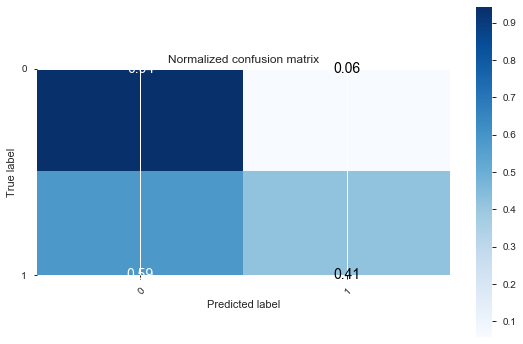

 Model: DT 
               precision    recall  f1-score   support

           0       0.86      0.87      0.86      4482
           1       0.60      0.59      0.60      1551

    accuracy                           0.79      6033
   macro avg       0.73      0.73      0.73      6033
weighted avg       0.79      0.79      0.79      6033
 


 Accuracy of the "DT" model =  79.48 % 

normalized confusion matrix of the "DT" model 
[[0.86590808 0.13409192]
 [0.41070277 0.58929723]]


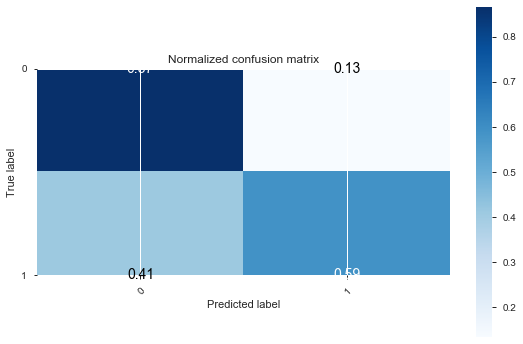

 Model: RF 
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      4482
           1       0.73      0.55      0.63      1551

    accuracy                           0.83      6033
   macro avg       0.79      0.74      0.76      6033
weighted avg       0.82      0.83      0.82      6033
 


 Accuracy of the "RF" model =  83.18 % 

normalized confusion matrix of the "RF" model 
[[0.92771084 0.07228916]
 [0.44551902 0.55448098]]


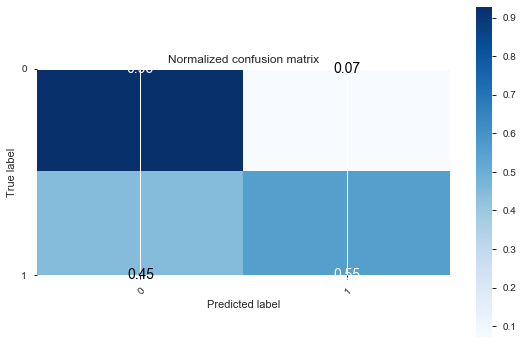

In [353]:
df_scores_none = accuracy_confusion(clsf_none, X_train, y_train, X_test, y_test) # original imbalanced data

In [355]:
df_scores_none  # print the accuracy of each classifier 

,Classifier,Score
0,RF,0.831759
1,LR,0.806067
2,DT,0.794795


### Comments on results (Imbalanced data)
Among the 3 classifiers used, the Random Forest Classifier (RF) has the highest accuracy (83.18%) of predicting adult income, then the Linear Regression Classifier (LR) with approximately (80.61%). The  Decision Tree (DT) has prediction accuracy of (79.48%).

### B- Balanced Data (class_weight = 'balanced')

 Model: LR 
               precision    recall  f1-score   support

           0       0.90      0.75      0.82      4482
           1       0.52      0.76      0.62      1551

    accuracy                           0.76      6033
   macro avg       0.71      0.76      0.72      6033
weighted avg       0.80      0.76      0.77      6033
 


 Accuracy of the "LR" model =  75.6 % 

normalized confusion matrix of the "LR" model 
[[0.75457385 0.24542615]
 [0.23984526 0.76015474]]


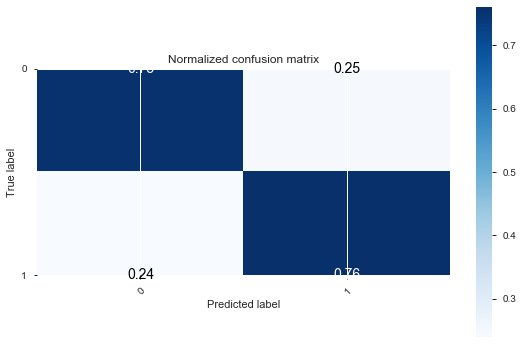

 Model: DT 
               precision    recall  f1-score   support

           0       0.86      0.87      0.86      4482
           1       0.60      0.59      0.59      1551

    accuracy                           0.79      6033
   macro avg       0.73      0.73      0.73      6033
weighted avg       0.79      0.79      0.79      6033
 


 Accuracy of the "DT" model =  79.41 % 

normalized confusion matrix of the "DT" model 
[[0.86546185 0.13453815]
 [0.41199226 0.58800774]]


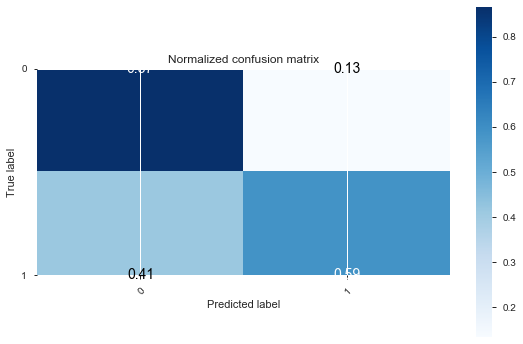

 Model: RF 
               precision    recall  f1-score   support

           0       0.85      0.93      0.89      4482
           1       0.73      0.53      0.62      1551

    accuracy                           0.83      6033
   macro avg       0.79      0.73      0.75      6033
weighted avg       0.82      0.83      0.82      6033
 


 Accuracy of the "RF" model =  82.83 % 

normalized confusion matrix of the "RF" model 
[[0.92994199 0.07005801]
 [0.46550613 0.53449387]]


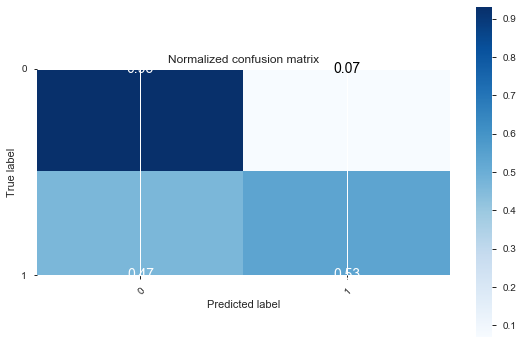

In [356]:
df_scores_balanced = accuracy_confusion(clsf_balanced, X_train, y_train, X_test, y_test) # using class_weight = 'balanced' 

In [357]:
df_scores_balanced # print the accuracy of each classifier class_weight = 'balanced'

,Classifier,Score
0,RF,0.828278
1,DT,0.794132
2,LR,0.756009


  
### Comments on results (class_weight = 'balanced')
In this case, the Random Forest Classifier (RF) has the highest accuracy (82.83%) of predicting adult income, then Decision Tree (DT) has prediction accuracy of (79.41%) and the Linear Regression Classifier (LR) with (75.60%). In general, the accuracies of the models have not improved, so that classifying using class_weight = 'balanced' does not work well with our data.

### C- Random Oversampling method
Finally, I will use the **random_over_sampling** function to create balanced dataset:


In [360]:
X_ros_train, y_ros_train = random_over_sampling(X_train, y_train) 

ros shape for features) :   (36344, 8)
ros shape for labels) :   (36344,)


In [363]:
Counter(y_ros_train)

Counter({0.0: 18172, 1.0: 18172})

In [367]:
print('ros no. of rows per class is balanced: ', dict(Counter(y_ros_train)))

ros no. of rows per class is balanced:  {0.0: 18172, 1.0: 18172}



Then, split the balanced data into train and test samples


Then, the accuracy and confusion matrix are obtained by using **randon oversampling** method

 Model: LR 
               precision    recall  f1-score   support

           0       0.90      0.76      0.82      4482
           1       0.52      0.76      0.62      1551

    accuracy                           0.76      6033
   macro avg       0.71      0.76      0.72      6033
weighted avg       0.80      0.76      0.77      6033
 


 Accuracy of the "LR" model =  75.7 % 

normalized confusion matrix of the "LR" model 
[[0.75591254 0.24408746]
 [0.23984526 0.76015474]]


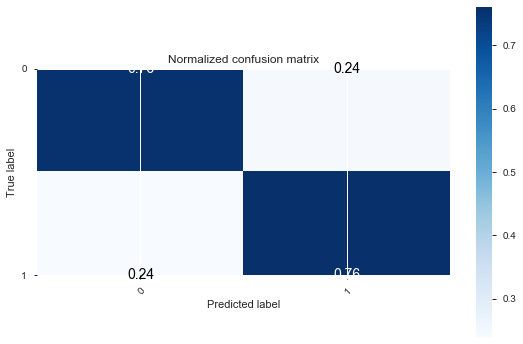

 Model: DT 
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      4482
           1       0.62      0.59      0.60      1551

    accuracy                           0.80      6033
   macro avg       0.74      0.73      0.74      6033
weighted avg       0.80      0.80      0.80      6033
 


 Accuracy of the "DT" model =  80.19 % 

normalized confusion matrix of the "DT" model 
[[0.8768407  0.1231593 ]
 [0.41457124 0.58542876]]


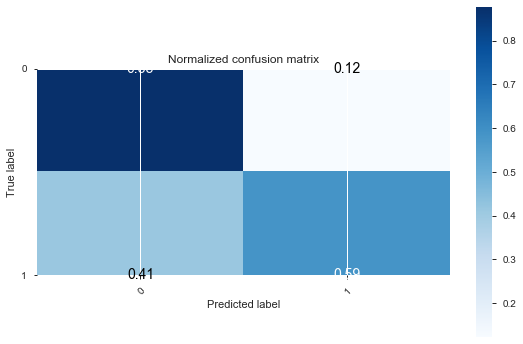

 Model: RF 
               precision    recall  f1-score   support

           0       0.87      0.90      0.88      4482
           1       0.67      0.62      0.64      1551

    accuracy                           0.82      6033
   macro avg       0.77      0.76      0.76      6033
weighted avg       0.82      0.82      0.82      6033
 


 Accuracy of the "RF" model =  82.36 % 

normalized confusion matrix of the "RF" model 
[[0.89580544 0.10419456]
 [0.38491296 0.61508704]]


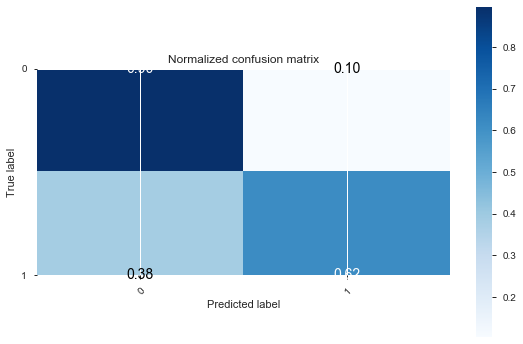

In [368]:
df_scores_ros_none = accuracy_confusion(clsf_none, X_ros_train, y_ros_train, X_test, y_test)  

In [369]:
df_scores_ros_none 

,Classifier,Score
0,RF,0.823637
1,DT,0.801923
2,LR,0.757003


### Comments on results (random oversampling- without smoking_status)
The results obtained here are not much better than **Sec. B**; the Random Forest Classifier (RF) has the highest accuracy (82.36%), then the Decision Tree (DT) with (80.19%). The Linear Regression Classifier (LR) has prediction accuracy of (75.70%) which is approximately the same when I used **class_weight = 'balanced'** in the previous section.

### - Conclusion
Classification of adult income is an interesting problem in machine learning. Many researchers/data scientists around the world attempted to solve it and then there are many approaches to deal with that problem. In my approach, the train data was downloaded from the UCI Machine Learning repository and a python code was created to read the data set. Then, the data was explored by using pandas profiling package. Before building a classification model, the data was split into two sets: training set consists of 80% of the whole sample and test set which has the rest of the data set. The adult income data consists of 14 features, and one target ['adult_income']. The main aim is to use the training data to train a model to fit the trained features with the trained labels, then the model will be used to predict labels of given features from the test set. Then, the predicted labels will be compared to the real ones and the accuracy of the model will be calculated.The higher the accuracy the best performance of the model. On modeling step, since I have no preferred approach to any model, I used 3 machine learning models to classify the data. To choose the best model among them, the accuracy of each model was calculated and the results were sorted according to the accuracy values. Meanwhile, the confusion matrix was calculated and shown to visualize the accuracy of the model. In general, the best model among others is the Random Forest Classifier (RF), its accuracy = 83.18% when I used the method explained on **Sec. A**.

Thank you for your time!